In [22]:
# my implementation of the Tensorflow example @
# https://github.com/tensorflow/tensorflow/blob/r1.3/tensorflow/examples/tutorials/mnist/mnist.py

from math import sqrt

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data, mnist
from matplotlib import pyplot as plt
import numpy as np

Extracting ../data/train-images-idx3-ubyte.gz
Extracting ../data/train-labels-idx1-ubyte.gz
Extracting ../data/t10k-images-idx3-ubyte.gz
Extracting ../data/t10k-labels-idx1-ubyte.gz


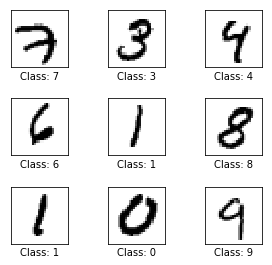

In [32]:
def plot_images(images, labels, predicted=None, amount_samples=9):
    side = int(sqrt(amount_samples))
    if side ** 2 != amount_samples:
        raise ValueError('amount_samples must be a perfect-square number.')
    
    fig, axes = plt.subplots(side, side)
    fig.subplots_adjust(hspace=0.3, wspace=0.7)
    fig.set_size_inches((side * 1.5, side * 1.5))

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(28, 28), cmap='binary')

        text = 'Class: ' + str(labels[i])
        if np.any(predicted):
            text += '\n Predicted: {}'.format(predicted[i])
            
        ax.set_xlabel(text)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()


# 1. handling the logging folder
if tf.gfile.Exists('./logs/'):
#     tf.gfile.DeleteRecursively('./logs/')
    pass
else:
    tf.gfile.MakeDirs('./logs')

# 2. fetching the dataset    
dataset = input_data.read_data_sets(train_dir='../data/')

# 3. taking a look on the data
amount_samples=9
plot_images(dataset.train.images[:amount_samples], dataset.train.labels[:amount_samples],
            amount_samples=amount_samples)

In [24]:
# 4. Encapsulating the model within a class
class Model:
    def __init__(self, batch_size=100, neta=0.01, beta=0, layer1_size=128, layer2_size=32):
        self.batch_size = batch_size
        self.neta = neta
        self.beta = beta
        
        self.input_size = mnist.IMAGE_PIXELS
        self.num_classes = 10
        
        self.input_placeholder = tf.placeholder(tf.float32, shape=(batch_size,
                                                                   self.input_size),
                                               name='input_samples')

        # it's not 1-hot vector
        self.label_placeholder = tf.placeholder(tf.int32, shape=(batch_size), name='input_labels')

        self.build_network(layer1_size, layer2_size)
        
    def get_input_placeholders(self):
        """Returns the interface to the TF model."""
        return self.input_placeholder, self.label_placeholder
    
    def build_network(self, amount_hidden1, amount_hidden2):
        """The architecture is input > ReLU > ReLU > logits. Returns the logits to be
        softmaxed."""
        
        with tf.name_scope('hidden_1'):
            self.w1 = tf.Variable(tf.truncated_normal([self.input_size, amount_hidden1],
                                      stddev=1.0/sqrt(self.input_size)))
            self.b1 = tf.Variable(tf.zeros([amount_hidden1]))

            hidden1 = tf.nn.relu(tf.matmul(self.input_placeholder, self.w1) + self.b1)
            
        with tf.name_scope('hidden_2'):
            self.w2 = tf.Variable(tf.truncated_normal([amount_hidden1, amount_hidden2],
                          stddev=1.0/sqrt(amount_hidden1)))
            self.b2 = tf.Variable(tf.zeros([amount_hidden2]))
            
            hidden2 = tf.nn.relu(tf.matmul(hidden1, self.w2) + self.b2)
            
        with tf.name_scope('softmax'):
            self.w3 = tf.Variable(tf.truncated_normal([amount_hidden2, self.num_classes],
                                                     stddev=1.0/sqrt(amount_hidden2)))
            self.b3 = tf.Variable(tf.zeros([self.num_classes]))

            self.logits = tf.matmul(hidden2, self.w3) + self.b3
            
        return self.logits
    
    def build_loss(self):
        """Builds the part responsible to calculate the loss function. This can be used to monitor convergence."""
        
        labels = tf.to_int64(self.label_placeholder)
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=self.label_placeholder, logits=self.logits, name='xentropy'
        )
        
        self.mean_xentropy = tf.reduce_mean(cross_entropy, name='xentropy_mean')
        return self.mean_xentropy
    
    def train(self):
        """The TF trainning op."""
        
        tf.summary.scalar('loss', self.mean_xentropy)
        self.optimizer = tf.train.GradientDescentOptimizer(self.neta)
        
        global_step = tf.Variable(0, name='global_step', trainable=False)
        self.train_op = self.optimizer.minimize(self.mean_xentropy, global_step=global_step)
        return self.train_op
    
    def evaluate(self):
        """Evaluates model's prediction."""
        
        # checks if the desired class in the top prediction. Removes the need for the softmax as this function
        # simply transforms scores into probabilities.
        correct = tf.nn.in_top_k(self.logits, self.label_placeholder, 1)
        return tf.reduce_sum(tf.cast(correct, tf.int32))
    
    def predict(self):
        """Calculaes the class probabilities for each class."""
        
        # Code repetition, argh!
        images_to_predict = tf.placeholder(tf.float32, shape=[None, self.input_size], name='pred_in')
        h1 = tf.nn.relu(tf.matmul(images_to_predict, self.w1) + self.b1)
        h2 = tf.nn.relu(tf.matmul(h1, self.w2) + self.b2)
        scores = tf.nn.relu(tf.matmul(h2, self.w3) + self.b3)
        
        return images_to_predict, tf.nn.softmax(scores, name='pred_out')

In [34]:
batch_size = 100
steps = 801
checkpoint_file = './logs/cpoint.ckpt'

def do_eval(s, eval_correct, images_placeholder, labels_placeholder, dataset):
    """Evaluates the model on validation set."""
    steps_per_epoch = dataset.num_examples // batch_size
    num_examples = steps_per_epoch * batch_size
    
    true_count = 0
    for step in range(steps_per_epoch):
        dt_images, dt_labels = dataset.next_batch(batch_size)
        feed_dict = {
            images_placeholder: dt_images,
            labels_placeholder: dt_labels
        }
        
        true_count += s.run(eval_correct, feed_dict)
    
    precision = float(true_count) / num_examples
    print('Evaluating on %d examples :: Precision: %.2f' % (num_examples, precision))

# 3. build the model
tf.reset_default_graph()    # this is to avoid problems when re-running Jupyter cells

model = Model(neta=0.5, layer1_size=128, layer2_size=32)
images_input, labels_input = model.get_input_placeholders()

# loss is used to monitor, train trains and eval to evaluate how to model is doing
loss = model.build_loss()
train_op = model.train()
eval_correct = model.evaluate()

s = tf.Session()
s.run(tf.global_variables_initializer())

# saving the model
saver = tf.train.Saver()
    
for step in range(steps):
    dt_images, dt_labels = dataset.train.next_batch(batch_size)
    feed_dict = {
        images_input: dt_images,
        labels_input: dt_labels
    }

    _, loss_value = s.run([train_op, loss], feed_dict=feed_dict)

    # summaries at every 100 batches
    if step % 100 == 0:
        print('Step %.3d\t loss = %.2f' %(step, loss_value))

    # checking and evaluation from time to time
    if (step+1) % 200 == 0 or step == steps:
        do_eval(s, eval_correct, images_input, labels_input, dataset.validation)
        saver.save(s, checkpoint_file, global_step=step+1)    # save the model

Step 000	 loss = 2.31
Step 100	 loss = 0.21
Evaluating on 5000 examples :: Precision: 0.93
Step 200	 loss = 0.25
Step 300	 loss = 0.17
Evaluating on 5000 examples :: Precision: 0.94
Step 400	 loss = 0.19
Step 500	 loss = 0.27
Evaluating on 5000 examples :: Precision: 0.96
Step 600	 loss = 0.16
Step 700	 loss = 0.13
Evaluating on 5000 examples :: Precision: 0.97
Step 800	 loss = 0.12


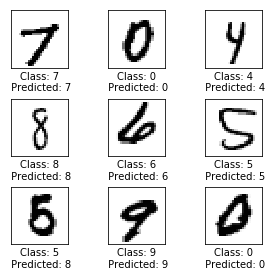

In [35]:
# The model is trained. Sample a few random examples to play with it

def classify_random_samples(input_placeholder, prediction_op, amount_samples=9):
    amount_test = len(dataset.test.images)
    i = np.random.randint(low=0, high=amount_test, size=amount_samples)

    probabilitites = s.run(prediction_op, {
        input_placeholder: dataset.train.images[i]
    })

    predicted_classes = probabilitites.argmax(axis=1)
    plot_images(dataset.train.images[i], dataset.train.labels[i], predicted_classes, amount_samples)

image_input, class_probs = model.predict()
classify_random_samples(image_input, class_probs)

INFO:tensorflow:Restoring parameters from ./logs/cpoint.ckpt-800


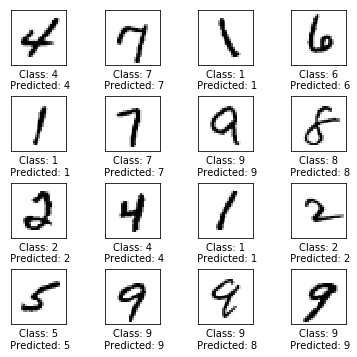

In [36]:
# Loading the stored model for futher predictions

with tf.Session() as s:
    saver = tf.train.import_meta_graph('./logs/cpoint.ckpt-800.meta')
    saver.restore(s, tf.train.latest_checkpoint('./logs/'))

    graph = tf.get_default_graph()
    input_samples = graph.get_tensor_by_name('pred_in:0')
    prediction_op   = graph.get_tensor_by_name('pred_out:0')

    classify_random_samples(input_samples, prediction_op, amount_samples=16)